In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

### **Загрузка food101**

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train', 'validation'],
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete7ATRPD/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete7ATRPD/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### **Визуализация**

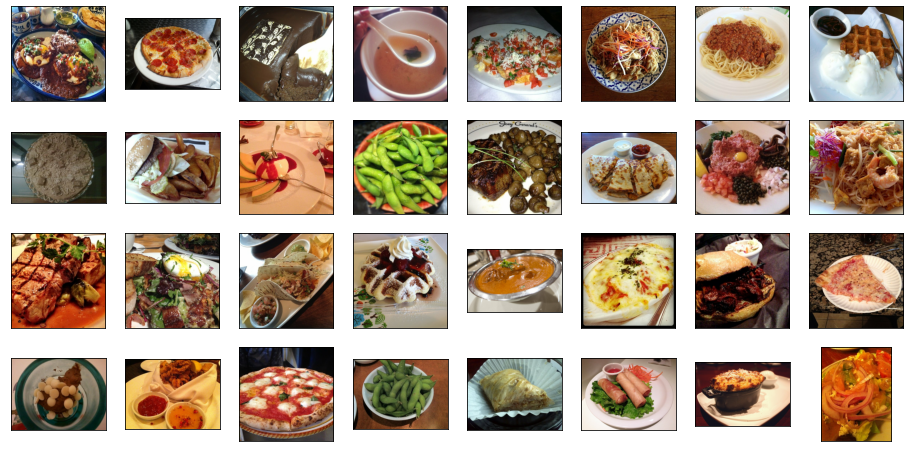

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

### **Подготовка и необходимые функции**

In [0]:
INP_SIZE = 160
NUM_EPOCHS = 5
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_EXAMPLES = 25000

In [0]:
# аугментация
def augment(img, label):
  img = tf.image.random_brightness(img, max_delta=0.3)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  img = tf.image.random_flip_left_right(img)
  img = tf.cast(img, tf.float32)/127. - 1.

  return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

In [0]:
# другое преобразование чисел в массиве, чтобы была возможность отрисовать картинки
def augment_to_show(img, label):
  img = tf.image.random_brightness(img, max_delta=0.3)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  img = tf.image.random_flip_left_right(img)
  img = tf.cast(img, tf.float32)/255

  return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

In [0]:
def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

In [0]:
aug_show_samples= (train_ds
                     .map(augment_to_show, num_parallel_calls=AUTOTUNE)
                     .prefetch(AUTOTUNE))

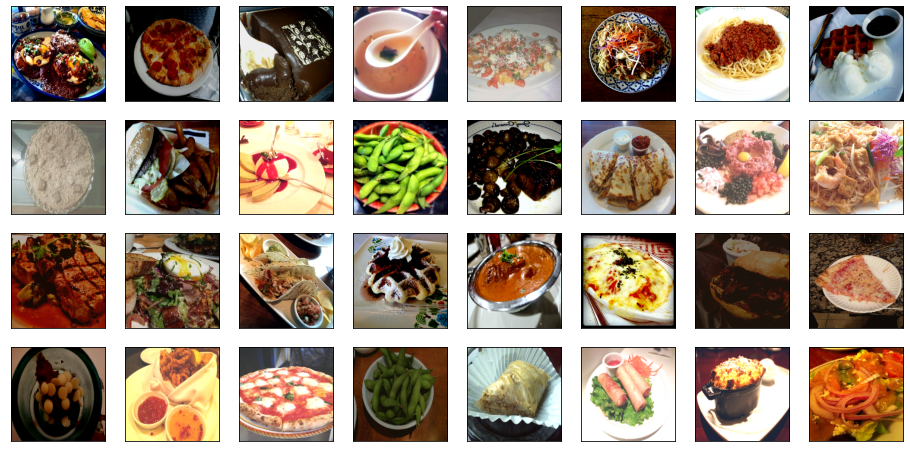

In [10]:
some_samples = [x[0] for x in iter(aug_show_samples.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
train_ds = train_ds.shuffle(buffer_size=1000)
non_aug_train_batches = (train_ds
                         .map(prepare, num_parallel_calls=AUTOTUNE)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTOTUNE))

aug_train_batches = (train_ds
                     .map(augment, num_parallel_calls=AUTOTUNE)
                     .batch(BATCH_SIZE)
                     .prefetch(AUTOTUNE))

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

#### **Подготовка модели CNN**

In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели
# base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

9412608/9406464 [==============================] - 0s 0us/step


#### **Подготовка к обучению**

In [0]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
%%time
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir='logs/'+'augmented', 
      write_graph=False, update_freq=100, profile_batch=0)
  
  history = model.fit(
      aug_train_batches,
      epochs=NUM_EPOCHS,
      validation_data=test_ds,
      callbacks=[tensorboard_callback])

Epoch 1/5
2368/2368 [==============================] - 673s 284ms/step - loss: 2.1697 - accuracy: 0.4693 - val_loss: 1.3541 - val_accuracy: 0.6355
Epoch 2/5
2368/2368 [==============================] - 676s 286ms/step - loss: 1.3744 - accuracy: 0.6401 - val_loss: 1.2274 - val_accuracy: 0.6776
Epoch 3/5
2368/2368 [==============================] - 643s 272ms/step - loss: 1.1168 - accuracy: 0.7016 - val_loss: 1.1472 - val_accuracy: 0.7003
Epoch 4/5
2368/2368 [==============================] - 642s 271ms/step - loss: 0.9466 - accuracy: 0.7414 - val_loss: 1.1872 - val_accuracy: 0.7067
Epoch 5/5
2368/2368 [==============================] - 643s 272ms/step - loss: 0.8134 - accuracy: 0.7736 - val_loss: 1.2449 - val_accuracy: 0.6936
CPU times: user 1h 34min 10s, sys: 6min 34s, total: 1h 40min 44s
Wall time: 55min 2s


In [15]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели
# base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+'not_augmented', 
    write_graph=False, update_freq=100, profile_batch=0)

history = model.fit(
    non_aug_train_batches,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/5
2368/2368 [==============================] - 414s 175ms/step - loss: 2.0410 - accuracy: 0.4979 - val_loss: 1.3146 - val_accuracy: 0.6460
Epoch 2/5
2368/2368 [==============================] - 415s 175ms/step - loss: 1.1709 - accuracy: 0.6891 - val_loss: 1.2283 - val_accuracy: 0.6817
Epoch 3/5
2368/2368 [==============================] - 416s 176ms/step - loss: 0.8382 - accuracy: 0.7686 - val_loss: 1.2964 - val_accuracy: 0.6835
Epoch 4/5
2368/2368 [==============================] - 415s 175ms/step - loss: 0.6002 - accuracy: 0.8302 - val_loss: 1.3646 - val_accuracy: 0.6840
Epoch 5/5
2368/2368 [==============================] - 414s 175ms/step - loss: 0.4280 - accuracy: 0.8770 - val_loss: 1.4404 - val_accuracy: 0.6670


In [16]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

Видно, что на неаугментированных данных модель сильнее пееробучилась: заметно падение точности на тесте по сравнению с тренироврочным набором. В модели, которая для обучения использовала аугментированные данные, переобучение заметно не так сильно, кроме того точность этой модели на тестовых данных выше.